# Task 2

#### Везде, если не будет оговорено иное, уровень значимости $\alpha$ будем полагать равным 0.05

In [2]:
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import statsmodels
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


#### Считаем данные

In [3]:
df_arima = pd.read_csv('data.csv',';', index_col=['date'],
                 parse_dates=True, dayfirst=True)
df_arima.head(2)

,period,fact,prediction,prev
date,,,,
2010-01-11,Дек ' 09,0.4,NaN,0.3
2010-02-03,Янв ' 10,1.6,NaN,0.4


In [4]:
df_arima['fact'] = df_arima['fact'].astype(float)

#### STL-декомпозиция ряда и проверка гипотезы о нестационарности ряда критерием Дики-Фуллера

Критерий Дики-Фуллера: p = 2.0269228702654347e-05


<Figure size 864x720 with 0 Axes>

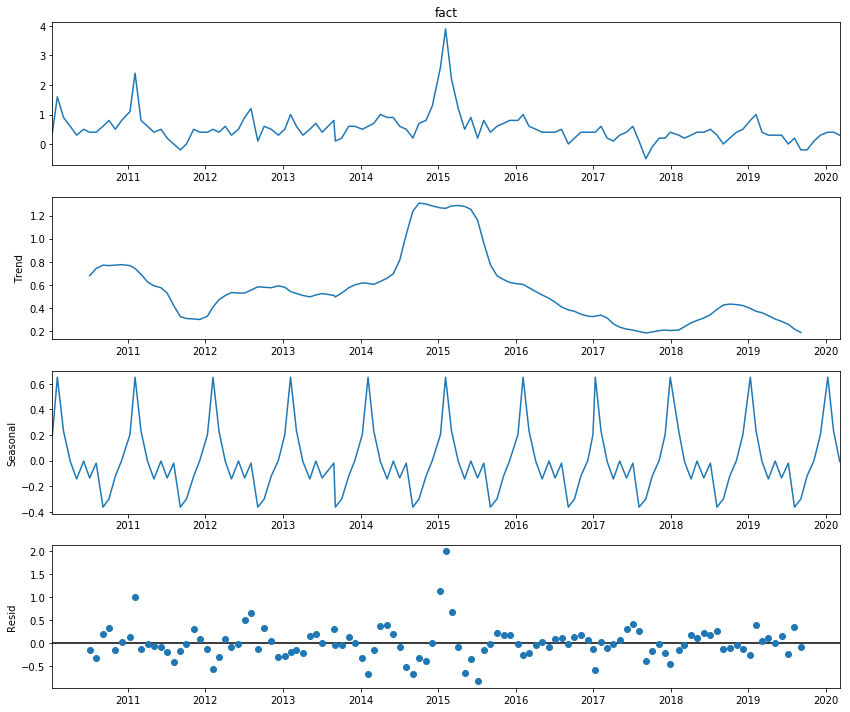

In [5]:
plt.figure(figsize(12,10))
sm.tsa.seasonal_decompose(df_arima['fact'], period=12).plot()
print(f"Критерий Дики-Фуллера: p = {sm.tsa.stattools.adfuller(df_arima['fact'], maxlag=14)[1]}")

На уровне значимсоти $\alpha$ гипотеза отвергается и ряд признается стационарным. Но наблюдается тренд в данных, что, вообще говоря, свидетельствует против его стационарности.

Поэтому применим дифференцирование к ряду.

Критерий Дики-Фуллера: p = 3.62320768280988e-08


<Figure size 864x720 with 0 Axes>

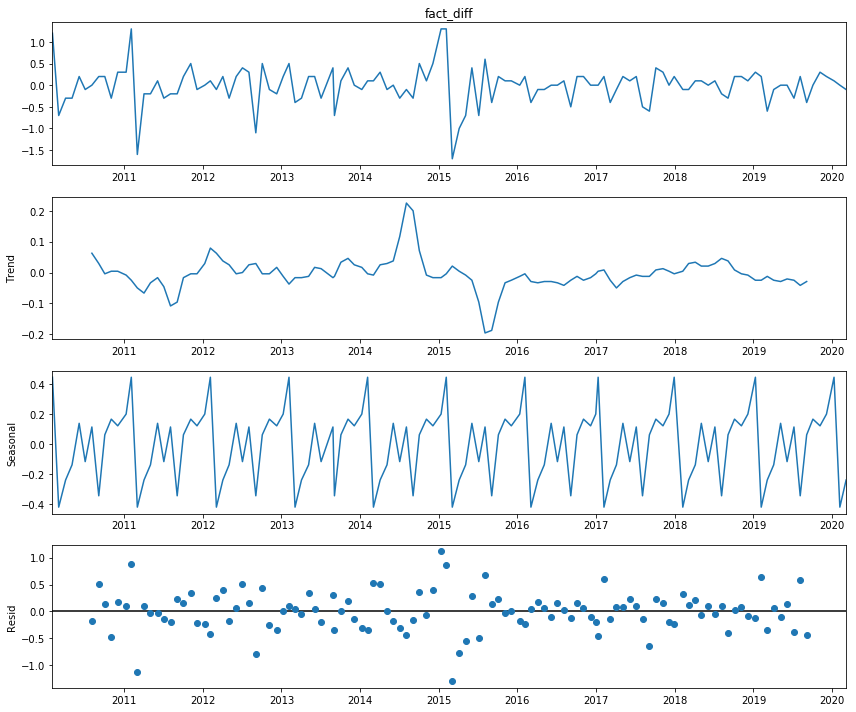

In [8]:
df_arima['fact_diff'] = df_arima['fact'] - df_arima['fact'].shift(1)
plt.figure(figsize(12,10))
sm.tsa.seasonal_decompose(df_arima['fact_diff'][1:], period=12).plot()
print(f"Критерий Дики-Фуллера: p = {sm.tsa.stattools.adfuller(df_arima['fact_diff'][1:])[1]}")

Гипотеза о нестационарности ряда также отвергается, что хорошо. К тому же теперь тренд колеблется около константы, а это то, что мы хотели получить. Плюс сам ряд теперь больше выглядит, как стационарный

## Подбор модели SARIMA

Посмотрим на ACF и PACF полученного ряда:

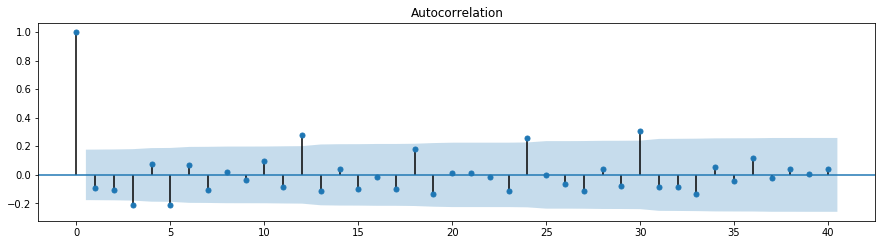

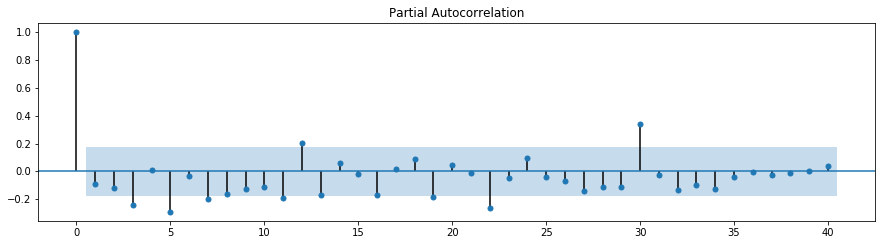

In [9]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df_arima['fact_diff'][1:].values.squeeze(), lags=40, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df_arima['fact_diff'][1:].values.squeeze(), lags=40, ax=ax)
pylab.show()

Начальные приближения: Q=1, q=5, P=1, p=5, d=1, D=0

Составим различные комбинации, исходя из начальных приближений

In [10]:
ps = range(0, 6)
ds = 1
qs = range(0, 6)
Ps = range(0, 2)
Ds = 0
Qs = range(0, 2)

In [11]:
from itertools import product
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

144

Построим SARIMA модели по полученным комбинациям параметров и посчитаем у каждой из них критерий Акаике (AIC) для отбора лучших моделей.

In [12]:
results = []
for param in parameters_list:
    model = sm.tsa.statespace.SARIMAX(df_arima['fact'], order=(param[0], ds, param[1]), 
                                      seasonal_order=(param[2], Ds, param[3], 12)).fit(disp=False, maxiter=1000)
    results.append([param[0], ds, param[1], param[2], Ds, param[3], model.aic])

Топ-5 моделей по критерию Акаике

In [14]:
result_table = pd.DataFrame(results, columns=['p', 'd', 'q', 'P', 'D', 'Q', 'aic'])
result_table = result_table.sort_values(by = 'aic', ascending=True)
print(result_table.head())

     p  d  q  P  D  Q         aic
115  4  1  4  1  0  1  115.039437
23   0  1  5  1  0  1  115.150992
47   1  1  5  1  0  1  116.029965
15   0  1  3  1  0  1  116.599022
91   3  1  4  1  0  1  116.714492


Так как в задаче сказано взять, как минимум 2 разумные модели, то возьмем лучшие 2

In [15]:
param1 = result_table.iloc[0, :]
param2 = result_table.iloc[1, :]

model1 = sm.tsa.statespace.SARIMAX(df_arima['fact'], order=(param1[0], param1[1], param1[2]),
                                   seasonal_order=(param1[3], param1[4], param1[5], 12)).fit(disp=False, maxiter=1000)
model2 = sm.tsa.statespace.SARIMAX(df_arima['fact'], order=(param2[0], param2[1], param2[2]),
                                   seasonal_order=(param2[3], param2[4], param2[5], 12)).fit(disp=False, maxiter=1000)

Загрузим критерии Шапиро-Уилка для проверки на нормальность и Льюинга-Бокса для проверки на неавтокоррелированность остатков модели

In [16]:
from scipy.stats import shapiro
from statsmodels.stats.diagnostic import acorr_ljungbox

In [18]:
def residuals_info(model):
    print(f"Критерий Шапиро-Уилка: p = {shapiro(model.resid)[1]}")
    print(f"Критерий Дики-Фуллера: p = {sm.tsa.stattools.adfuller(model.resid[1:])[1]}")
    print(f"Критерий Льюнг-Бокса:  p = {acorr_ljungbox(model.resid, lags=[14], return_df=False)[1][0]}")
    
    plt.figure(figsize(15,8))
    plt.subplot(211)
    model.resid[1:].plot()
    plt.ylabel(u'Residuals')

    ax = plt.subplot(212)
    sm.graphics.tsa.plot_acf(model.resid[1:].values.squeeze(), lags=25, ax=ax)
    
    sm.qqplot(model.resid[1:], line='r') #вроде надо [1:] делать но и без него отрабатывало

Проверим гипотезы о нормальности остатков критерием Шапиро-Уилка, неавтокоррелированности остатков критерим Льюинга-Бокса и заодно гипотезу о нестационарности остатков критерием Дики-Фуллера.

Также построим график остатков, их ACF для визуальной проверки на неавтокоррелированность и QQ-график для визуальной проверки на нормальность

Критерий Шапиро-Уилка: p = 1.630276983632939e-06
Критерий Дики-Фуллера: p = 4.132439329850335e-21
Критерий Льюнг-Бокса:  p = 0.9642183946884127


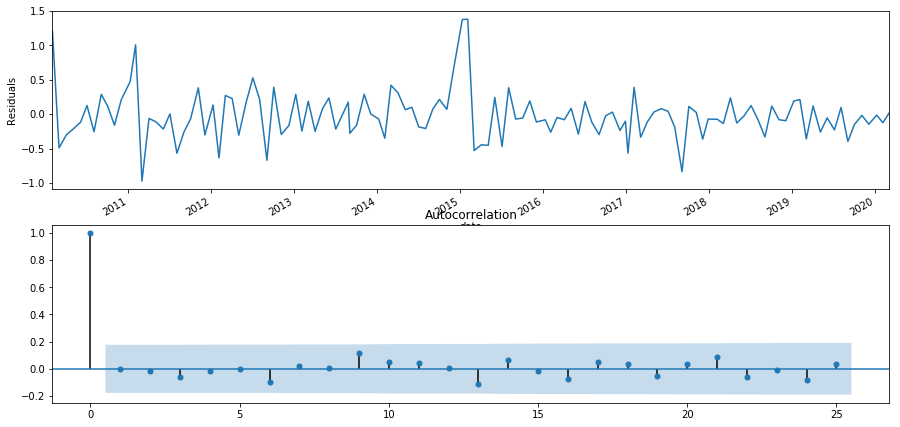

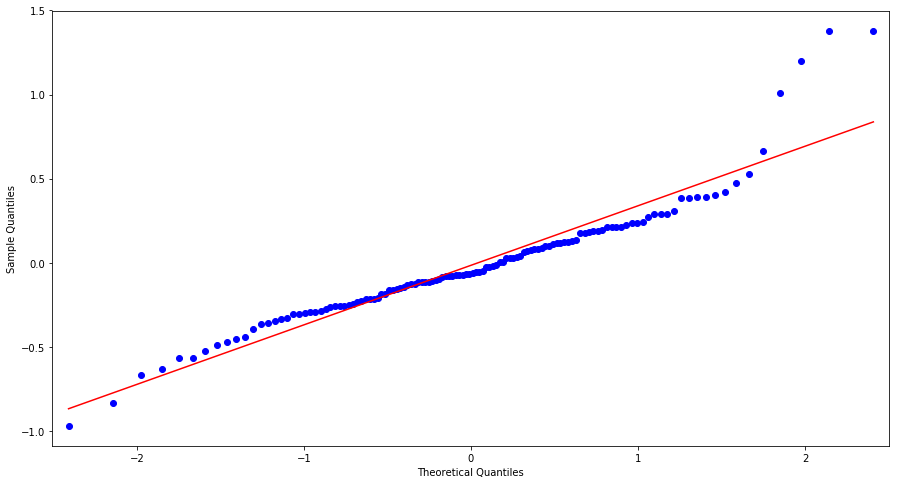

In [19]:
residuals_info(model1)

Из полученных критериев и графиков следует, что для модели SARIMA(4, 1, 4)x(1, 0, 1) остатки неавтокоррелированы, стационарны, но не имеют нормального распределения, что также видно на QQ-графике - тяжелые хвосты

Аналогично для второй модели

Критерий Шапиро-Уилка: p = 3.7221133197817835e-07
Критерий Дики-Фуллера: p = 5.364635658558994e-21
Критерий Льюнг-Бокса:  p = 0.9853253821650589


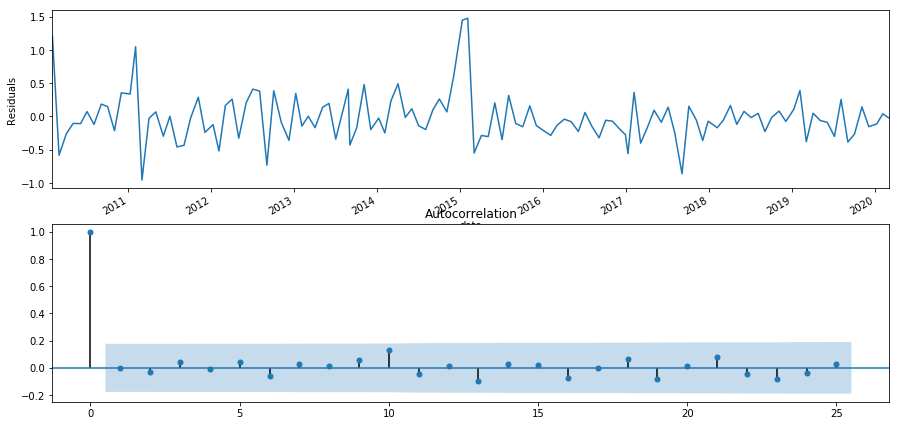

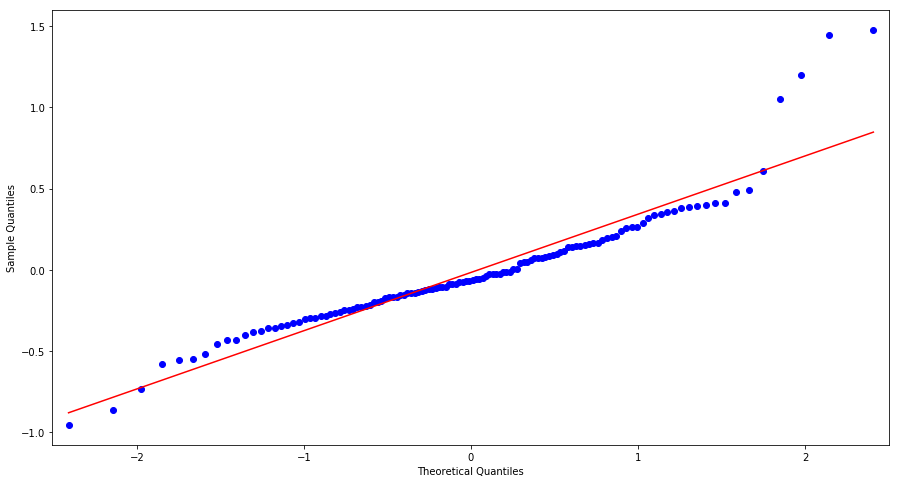

In [20]:
residuals_info(model2)

Из полученных критериев и графиков следует, что для модели SARIMA(0, 1, 5)x(1, 0, 1) остатки неавтокоррелированы, стационарны, но не имеют нормального распределения, что также видно на QQ-графике - тяжелые хвосты

Из полученных результатов можно сделать вывод, что модель SARIMA(4, 1, 4)x(1, 0, 1) лучше. Воспользуемся ее для предсказания на период сезонности

In [22]:
best_model = model1

### Прогноз по полученной модели SARIMA

Укоротим ряд на период сезонности и сделаем для него предсказание на данный период.

Посчитаем накопленный модуль ошибки прогноза в убранном отрезке ряда

In [23]:
date_list = df_arima[-12:].index
df_arima_pred = pd.DataFrame(columns=['arima_pred', 'fact'], index=date_list)
df_arima_pred['arima_pred'] = best_model.predict(start=len(df_arima)-12, end=len(df_arima)-1)
df_arima_pred['fact'] = df_arima.iloc[-12:, 1]

Визуализируем то, что получили

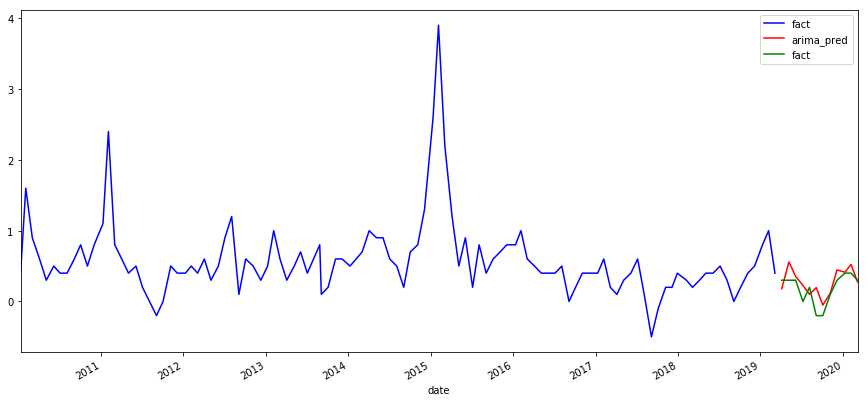

In [32]:
plt.figure(figsize(15,7))
df_arima.iloc[:-12, 1].plot(color='b')
df_arima_pred.loc[:, 'arima_pred'].plot(color='r', legend='pred')
df_arima_pred.loc[:, 'fact'].plot(color='g', legend='fact')
plt.legend(loc='best')
plt.show()

In [40]:
ae = sum(abs(df_arima_pred.loc[:,'arima_pred'].values - df_arima_pred.loc[:, 'fact'].values))
print(f"Накопленный модуль ошибки: {ae}")

Накопленный модуль ошибки: 1.6276911564277405


## Модель Хольта-Винтерса

Почитать можно тут: https://uncoolai.com/exponential-smoothing-for-time-series-forecasting/

In [41]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [42]:
df_holt = pd.read_csv('data.csv',';', index_col=['date'],
                 parse_dates=True, dayfirst=True)
df_holt.head()

,period,fact,prediction,prev
date,,,,
2010-01-11,Дек ' 09,0.4,NaN,0.3
2010-02-03,Янв ' 10,1.6,NaN,0.4
2010-03-04,Фев ' 10,0.9,NaN,01.июнь
2010-04-05,Мар ' 10,0.6,NaN,0.9
2010-05-05,Апр ' 10,0.3,0.5,0.6


In [43]:
df_holt.loc[:, 'fact'] = df_holt['fact'].astype(float)
df_holt = df_holt.set_index(pd.Series(pd.date_range('1/1/2010', '1/1/2021', freq='M'))[:-9])

Сделаем предсказание на период сезонности при помощи модели Хольта-Винтерса

In [45]:
train, test = df_holt.iloc[:-12, 1], df_holt.iloc[-12:, 1]
model = ExponentialSmoothing(train, seasonal='additive', seasonal_periods=12, freq='M')
model = model.fit()
pred = model.predict(start=test.index[0], end=test.index[-1])

Визуализируем то, что получили

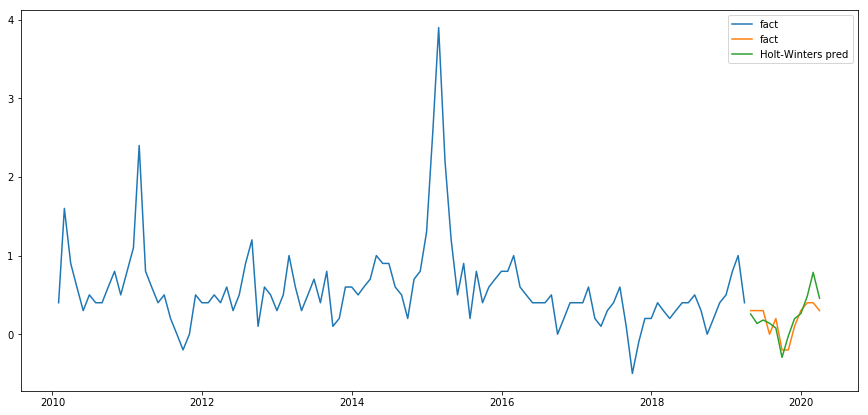

In [47]:
plt.figure(figsize(15,7))
plt.plot(train.index, train, label='fact')
plt.plot(test.index, test, label='fact')
plt.plot(pred.index, pred, label='Holt-Winters pred')
plt.legend(loc='best')

In [48]:
ae = sum(abs(pred - df_arima_pred.loc[:, 'fact']))
print(f"Накопленный модуль ошибки: {ae}")

Накопленный модуль ошибки: 1.62181272827697


Mодель SARIMA немного уступает модели Хольта-Винтерса, судя по накопленному модулю ошибки

## Построим все вместе

In [49]:
df = pd.DataFrame(columns = ['arima_pred', 'holt_pred', 'fact'], index=date_list)
df['arima_pred'] = df_arima_pred['arima_pred'].values
df['fact'] = df_arima_pred['fact'].values
df['holt_pred'] = pred.values

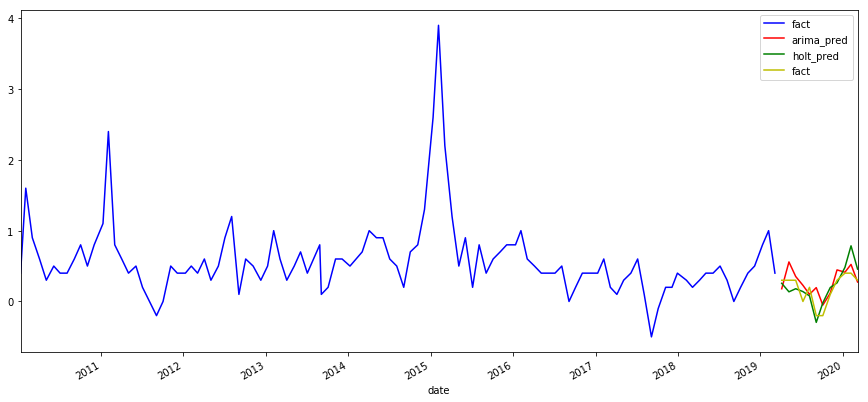

In [50]:
plt.figure(figsize(15,7))

df_arima.iloc[:-12, 1].plot(color='b', legend='fact')
df['arima_pred'].plot(color='r', legend='arima pred')
df['holt_pred'].plot(color='g', legend='holt pred')
df['fact'].plot(color='y', legend='fact')
plt.legend(loc='best')

### Вывод: 
К временному ряду была подобрана модель SARIMA, исходя из критерий Акаике и ACF, PACF графиков, произведен анализ ее остатков и сделан прогноз на период сезонности, также построена модель Хольта-Винтерса, предсказан тот же самый период сезонности.

Из накопленного модуля ошибки прогноза и факта следует, что модель Хольта-Винтерса лучше